In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
import time

import matplotlib.pyplot as plt
%matplotlib inline
from multiprocess import Pool
import numpy as np
# from scipy.interpolate import RectBivariateSpline
# from skimage.transform import resize
from scipy.ndimage.interpolation import map_coordinates

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *
from metadata import *
from data_manager import *
from learning_utilities import *

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


Setting environment for AWS compute node


No vtk
File does not exist: /shared/CSHL_data_processed/MD635/MD635_anchor.txt
File does not exist: /shared/CSHL_data_processed/MD635/MD635_sorted_filenames.txt
File does not exist: /shared/CSHL_data_processed/MD635/MD635_cropbox.txt
File does not exist: /shared/CSHL_data_processed/MD635/MD635_cropbox.txt
File does not exist: /shared/CSHL_data_processed/MD653/MD653_anchor.txt
File does not exist: /shared/CSHL_data_processed/MD653/MD653_sorted_filenames.txt
File does not exist: /shared/CSHL_data_processed/MD653/MD653_cropbox.txt
File does not exist: /shared/CSHL_data_processed/MD653/MD653_cropbox.txt
File does not exist: /shared/CSHL_data_processed/MD652/MD652_anchor.txt
File does not exist: /shared/CSHL_data_processed/MD652/MD652_sorted_filenames.txt
File does not exist: /shared/CSHL_data_processed/MD652/MD652_cropbox.txt
File does not exist: /shared/CSHL_data_processed/MD652/MD652_cropbox.txt
File does not exist: /shared/CSHL_data_processed/MD642/MD642_anchor.txt
File does not exist: 

In [2]:
classifier_id = 30

In [3]:
# What is the preferred and efficient approach for interpolating multidimensional data?
# http://scicomp.stackexchange.com/questions/19137/what-is-the-preferred-and-efficient-approach-for-interpolating-multidimensional
# http://nbviewer.jupyter.org/github/pierre-haessig/stodynprog/blob/master/stodynprog/linear_interp_benchmark.ipynb

# Downscaled

In [5]:
downscale = 32

In [6]:
# n_structures = len(all_structures_with_classifiers)
# label_to_structure_map = dict(enumerate(all_structures_with_classifiers))
# structure_to_label_map = {s: l for l, s in label_to_structure_map.iteritems()}

In [4]:
# Parallel

for stack in ['MD591']:
                
    patch_size, spacing, w, h = get_default_gridspec(stack)
    half_size = patch_size/2
    
    first_sec, last_sec = metadata_cache['section_limits'][stack]
    
    def resample(sec):
    
        if is_invalid(stack=stack, sec=sec):
            return

#         t = time.time()

        _, sample_locations_roi = DataManager.load_dnn_feature_locations(stack=stack, 
                                            model_name='Inception-BN', section=sec)

        actual_setting = resolve_actual_setting(setting=classifier_id, stack=stack, sec=sec)
        
        downscaled_grid_y = np.arange(0, h, downscale)
        downscaled_grid_x = np.arange(0, w, downscale)
        downscaled_ny = len(downscaled_grid_y)
        downscaled_nx = len(downscaled_grid_x)
                
        for structure in all_structures_with_classifiers:
            try:
                sparse_scores = DataManager.load_sparse_scores(stack, sec=sec,
                                                               structure=structure, 
                                                               setting=actual_setting)
            except Exception as e:
                sys.stderr.write('Error loading for %s do not exist.\n' % structure)
                continue

            f_grid = np.zeros(((h-half_size)/spacing+1, (w-half_size)/spacing+1))
            a = (sample_locations_roi - half_size)/spacing
            f_grid[a[:,1], a[:,0]] = sparse_scores

            yinterps = (downscaled_grid_y - half_size)/float(spacing)
            xinterps = (downscaled_grid_x - half_size)/float(spacing)

            points_y, points_x = np.broadcast_arrays(yinterps.reshape(-1,1), xinterps)
            coord = np.c_[points_y.flat, points_x.flat]
            f_interp = map_coordinates(f_grid, coord.T, order=1)
            f_interp_2d = f_interp.reshape((downscaled_ny, downscaled_nx))                       

            scoremap_bp_filepath = \
            DataManager.get_downscaled_scoremap_filepath(stack=stack, section=sec, 
                                                         structure=structure, 
                                                         setting=actual_setting,
                                                        downscale=downscale)

            create_parent_dir_if_not_exists(scoremap_bp_filepath)
            bp.pack_ndarray_file(f_interp_2d.astype(np.float16), scoremap_bp_filepath)

#         sys.stderr.write('interpolate %d: %.2f seconds\n' % (sec, time.time() - t)) 
    
    t = time.time()
    
    pool = Pool(NUM_CORES/2)
    pool.map(resample, range(first_sec, last_sec+1))
    pool.close()
    pool.join()
    
    sys.stderr.write('Interpolate: %.2f seconds\n' % (time.time() - t)) 

interpolate: 1.14 seconds
interpolate: 1.20 seconds
interpolate: 1.21 seconds
interpolate: 1.21 seconds
interpolate: 1.24 seconds
interpolate: 1.31 seconds
interpolate: 1.46 seconds
interpolate: 1.47 seconds
interpolate: 1.04 seconds
interpolate: 1.12 seconds
interpolate: 1.07 seconds
interpolate: 1.15 seconds
interpolate: 1.07 seconds
interpolate: 1.17 seconds
interpolate: 1.09 seconds
interpolate: 1.16 seconds
interpolate: 1.05 seconds
interpolate: 1.02 seconds
interpolate: 1.28 seconds
interpolate: 1.26 seconds
interpolate: 1.22 seconds
interpolate: 1.22 seconds
interpolate: 1.16 seconds
interpolate: 1.35 seconds
interpolate: 1.01 seconds
interpolate: 1.19 seconds
interpolate: 1.06 seconds
interpolate: 1.10 seconds
interpolate: 1.28 seconds
interpolate: 1.40 seconds
interpolate: 1.52 seconds
interpolate: 1.12 seconds
interpolate: 1.10 seconds
interpolate: 1.08 seconds
interpolate: 1.26 seconds
interpolate: 1.14 seconds
interpolate: 1.17 seconds
interpolate: 1.06 seconds
interpolate:

In [6]:
# Sequential

for stack in ['MD585']:
                
    patch_size, spacing, w, h = get_default_gridspec(stack)
    half_size = patch_size/2
    
    first_sec, last_sec = metadata_cache['section_limits'][stack]
    bar = show_progress_bar(first_sec, last_sec)

    for sec in range(203, 204):
#     for sec in range(first_sec, last_sec+1):

        bar.value = sec
        
        if is_invalid(stack=stack, sec=sec):
            continue

        t = time.time()

        _, sample_locations_roi = DataManager.load_dnn_feature_locations(stack=stack, model_name='Inception-BN', section=sec)

        actual_setting = resolve_actual_setting(setting=classifier_id, stack=stack, sec=sec)
        
        for structure in all_known_structures:
            try:
                sparse_scores = DataManager.load_sparse_scores(stack, sec=sec,
                                                               structure=structure, setting=actual_setting)
            except Exception as e:
                sys.stderr.write('Error loading for %s do not exist.\n' % structure)
                continue
                
            f_grid = np.zeros(((h-half_size)/spacing+1, (w-half_size)/spacing+1))
            a = (sample_locations_roi - half_size)/spacing
            f_grid[a[:,1], a[:,0]] = sparse_scores

            yinterps = (np.arange(0, h, downscale) - half_size)/float(spacing)
            xinterps = (np.arange(0, w, downscale) - half_size)/float(spacing)

            points_y, points_x = np.broadcast_arrays(yinterps.reshape(-1,1), xinterps)
            coord = np.c_[points_y.flat, points_x.flat]
            f_interp = map_coordinates(f_grid, coord.T, order=1)
            f_interp_2d = f_interp.reshape((len(yinterps), len(xinterps)))

            scoremap_bp_filepath = \
            DataManager.get_downscaled_scoremap_filepath(stack=stack, section=sec, 
                                                         structure=structure, 
                                                         setting=actual_setting,
                                                        downscale=downscale)

            create_parent_dir_if_not_exists(scoremap_bp_filepath)
#             save_hdf(f_interp_2d.astype(np.float16), scoremap_bp_filepath, complevel=5)
            bp.pack_ndarray_file(f_interp_2d.astype(np.float16), scoremap_bp_filepath)
 
        sys.stderr.write('interpolate: %.2f seconds\n' % (time.time() - t)) 

Widget Javascript not detected.  It may not be installed or enabled properly.


File does not exist: /shared/CSHL_patch_scores/MD585/MD585-N36-2015.07.16-21.53.31_MD585_3_0108_lossless_alignedTo_MD585-N47-2015.07.16-22.50.52_MD585_3_0141_cropped/MD585-N36-2015.07.16-21.53.31_MD585_3_0108_lossless_alignedTo_MD585-N47-2015.07.16-22.50.52_MD585_3_0141_cropped_sp5_sparseScores_setting_30.hdf
Error loading for sp5 do not exist.
File does not exist: /shared/CSHL_patch_scores/MD585/MD585-N36-2015.07.16-21.53.31_MD585_3_0108_lossless_alignedTo_MD585-N47-2015.07.16-22.50.52_MD585_3_0141_cropped/MD585-N36-2015.07.16-21.53.31_MD585_3_0108_lossless_alignedTo_MD585-N47-2015.07.16-22.50.52_MD585_3_0141_cropped_outerContour_sparseScores_setting_30.hdf
Error loading for outerContour do not exist.
interpolate: 0.93 seconds


# Read

In [18]:
sm = DataManager.load_downscaled_scoremap(stack='MD642', structure='7N', setting=2, section=155)

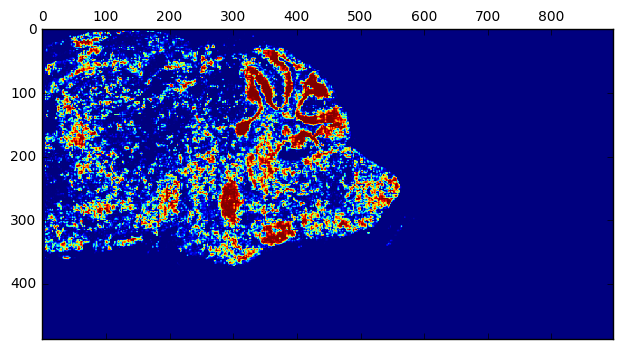

In [19]:
plt.matshow(sm);

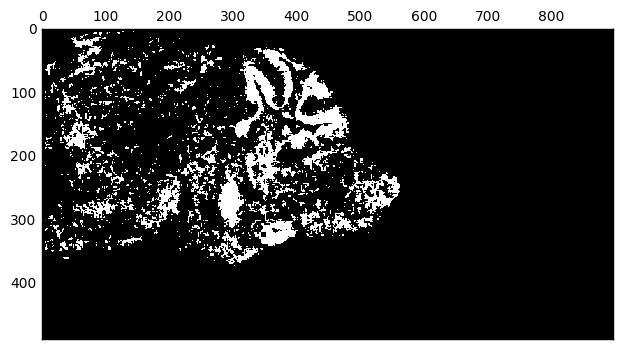

In [20]:
plt.matshow(sm > 0.5, cmap=plt.cm.gray);

# Lossless

In [ ]:
# New method - NOT faster than old method.

In [67]:
yinterp = (np.arange(0, h)-half_size)/float(spacing)
xinterp = (np.arange(0, w)-half_size)/float(spacing)

In [38]:
t = time.time()
points_y, points_x = np.broadcast_arrays(yinterp.reshape(-1,1), xinterp)
coord = np.c_[points_y.flat, points_x.flat]
f_2d_interp = map_coordinates(p, coord.T, order=1)
print time.time() - t # 27s

53.5506660938


In [39]:
f_2d_interp.shape

(441467377,)

In [40]:
q = f_2d_interp.reshape((15457, 28561))

In [41]:
viz = plt.cm.hot(q[::8,::8])

In [42]:
display_image(img_as_ubyte(viz)[..., :3])

/oasis/projects/nsf/csd395/yuncong/Brain/learning/tmp.jpg

In [ ]:
f_2d_interp = map_coordinates(f_2d_grid, coord, order=1).reshape(len(xinterp), len(yinterp))

plt.imshow(f_2d_interp.T)
plt.title(u'interpolation of a 2D function ({}² pts)'.format(Ninterp));

In [19]:
# Old Method

In [5]:
for stack in ['MD642']:
        
    sections_to_filenames = metadata_cache['sections_to_filenames'][stack]
    first_sec, last_sec = metadata_cache['section_limits'][stack]
    anchor_fn = metadata_cache['anchor_fn'][stack]
        
    bar = show_progress_bar(first_sec, last_sec)
    
#     for sec in range(193, 194):
    for sec in range(first_sec, last_sec+1):

        actual_setting = resolve_actual_setting(setting=setting, stack=stack, sec=sec)

        bar.value = sec
        
        print sec

        fn = sections_to_filenames[sec]
        if is_invalid(fn):
            continue     

        # output
        scoremaps_dir = create_if_not_exists(os.path.join(SCOREMAPS_ROOTDIR, stack, 
                                     '%(fn)s_lossless_alignedTo_%(anchor_fn)s_cropped' % \
                                     dict(stack=stack, fn=fn, anchor_fn=anchor_fn)))

        ## define grid, generate patches

        t = time.time()

        _, sample_locations_roi = DataManager.load_dnn_feature_locations(stack=stack, model_name='Sat16ClassFinetuned', fn=fn, anchor_fn=anchor_fn)
        
#         locations_fn = os.path.join(PATCH_FEATURES_ROOTDIR, \
#         '%(stack)s/%(fn)s_lossless_alignedTo_%(anchor_fn)s_cropped/%(fn)s_lossless_alignedTo_%(anchor_fn)s_cropped_patch_locations.txt' % dict(stack=stack, fn=fn, anchor_fn=anchor_fn))

#         with open(locations_fn, 'r') as f:
#             sample_locations_roi = np.array([map(int, line.split()[1:]) for line in f.readlines()])
        
        ## interpolate
        
        interpolation_xmin, interpolation_ymin = sample_locations_roi.min(axis=0)
        interpolation_xmax, interpolation_ymax = sample_locations_roi.max(axis=0)
        interpolation_w = interpolation_xmax - interpolation_xmin + 1
        interpolation_h = interpolation_ymax - interpolation_ymin + 1

        ##### sample_locations_roi + scores to dense_score_map #####

        shrink_factor = 4 # do interpolation on a smaller grid, then resize to original dimension

        sample_locations_unique_xs = np.unique(sample_locations_roi[:,0])
        sample_locations_unique_ys = np.unique(sample_locations_roi[:,1])

        n_sample_x = sample_locations_unique_xs.size
        n_sample_y = sample_locations_unique_ys.size

        index_x = dict([(j,i) for i,j in enumerate(sample_locations_unique_xs)])
        index_y = dict([(j,i) for i,j in enumerate(sample_locations_unique_ys)])
        sample_location_indices = np.asarray([(index_x[x], index_y[y]) for x, y in sample_locations_roi])

        sample_locations_interpolatedArea_ys_matrix, \
        sample_locations_interpolatedArea_xs_matrix = np.meshgrid(range(interpolation_ymin/shrink_factor, 
                                                                        interpolation_ymax/shrink_factor), 
                                                                  range(interpolation_xmin/shrink_factor, 
                                                                        interpolation_xmax/shrink_factor), 
                                                                  indexing='ij')

#         sparse_score_dir = create_if_not_exists(os.path.join(SPARSE_SCORES_ROOTDIR, stack, '%(fn)s_lossless_alignedTo_%(anchor_fn)s_cropped' % \
#                                       {'fn': fn, 'anchor_fn': anchor_fn}))

#         probs_allClasses = {label: bp.unpack_ndarray_file(sparse_score_dir + '/%(fn)s_lossless_alignedTo_%(anchor_fn)s_cropped_%(label)s_sparseScores.hdf' % \
#                     {'fn': fn, 'anchor_fn': anchor_fn, 'label':label})
#                             for label in structures}

        probs_allClasses = {}
        for structure in all_known_structures:
            try:
                probs_allClasses[structure] = DataManager.load_sparse_scores(stack, fn=fn, anchor_fn=anchor_fn,
                                                                         structure=structure, setting=actual_setting)
            except Exception as e:
                sys.stderr.write('Patch predictions for %s do not exist.\n' % structure)

        structures = probs_allClasses.keys()
                
        sys.stderr.write('preprocess: %.2f seconds\n' % (time.time() - t)) # 3s
        
        def generate_score_map(structure):

            if structure == 'BackG':
                return None
            
            score_matrix = np.zeros((n_sample_x, n_sample_y))
            score_matrix[sample_location_indices[:,0], sample_location_indices[:,1]] = probs_allClasses[structure]

            spline = RectBivariateSpline(sample_locations_unique_xs/shrink_factor, 
                                         sample_locations_unique_ys/shrink_factor, 
                                         score_matrix, 
                                         bbox=[interpolation_xmin/shrink_factor, 
                                               interpolation_xmax/shrink_factor, 
                                               interpolation_ymin/shrink_factor, 
                                               interpolation_ymax/shrink_factor])

            t1 = time.time()
            dense_score_map = spline.ev(sample_locations_interpolatedArea_xs_matrix, 
                                        sample_locations_interpolatedArea_ys_matrix)
            sys.stderr.write('evaluate spline: %.2f seconds\n' % (time.time() - t1)) # 5s for shrink_factor=4; doubling results in quadratic time reduction
            
            t1 = time.time()
            dense_score_map = resize(dense_score_map, (interpolation_h, interpolation_w)) # similar speed as rescale
#             dense_score_map = rescale(dense_score_map, shrink_factor)
            sys.stderr.write('scale up: %.2f seconds\n' % (time.time() - t1)) # 10s, very high penalty when multiprocessing

#             t = time.time()
            dense_score_map[dense_score_map < 1e-1] = 0
            dense_score_map[dense_score_map > 1.] = 1.
#             sys.stderr.write('threshold: %.2f seconds\n' % (time.time() - t))

            if np.count_nonzero(dense_score_map) < 1e5:
                sys.stderr.write('No %s is detected on section %d.\n' % (structure, sec))
                return None
            
            t1 = time.time()
            
            scoremap_bp_filepath, scoremap_interpBox_filepath = \
            DataManager.get_scoremap_filepath(stack=stack, fn=fn, anchor_fn=anchor_fn, structure=structure, 
                                              return_bbox_fp=True, setting=actual_setting)
            
            save_hdf(dense_score_map.astype(np.float16), scoremap_bp_filepath, complevel=5)
#             save_hdf(dense_score_map.astype(np.float16), '/home/yuncong/tmp_%s.hdf' % structure, complevel=5)
            np.savetxt(scoremap_interpBox_filepath,
                   np.array((interpolation_xmin, interpolation_xmax, interpolation_ymin, interpolation_ymax))[None],
                   fmt='%d')
    
            sys.stderr.write('save: %.2f seconds\n' % (time.time() - t1)) # 4s, very high penalty when multiprocessing
            
        
        t = time.time()
        
        # if too many disk saves are simultaneous, they will be conflicting, so split into two sessions
#         for i in range(0, len(structures), 8):
#             _ = Parallel(n_jobs=16)(delayed(generate_score_map)(l) for l in structures[i:i+15])
    
#         for l in structures:
#             _ = generate_score_map(l)

        # Each generate_score_map() takes 20s
        # Parallel, expect 20*28/4=140s

#         _ = Parallel(n_jobs=15)(delayed(generate_score_map)(l) for l in structures)

        pool = Pool(4) # 8 causes contention, resuls in high upscaling and dumping to disk time.
        _ = pool.map(generate_score_map, structures)
        pool.close()
        pool.join()
 
        sys.stderr.write('interpolate: %.2f seconds\n' % (time.time() - t)) # 80s-150s / section, 8 processes
    # 360s (6mins) / section, 4 processes

193


File does not exist: /oasis/projects/nsf/csd395/yuncong/CSHL_sparse_scoremaps/MD642/MD642-N38-2017.01.19-11.27.28_MD642_2_0113_lossless_alignedTo_MD642-F53-2017.01.14-12.23.43_MD642_1_0157_cropped/MD642-N38-2017.01.19-11.27.28_MD642_2_0113_lossless_alignedTo_MD642-F53-2017.01.14-12.23.43_MD642_1_0157_cropped_sp5_sparseScores_setting_2.hdf
Patch predictions for sp5 do not exist.
File does not exist: /oasis/projects/nsf/csd395/yuncong/CSHL_sparse_scoremaps/MD642/MD642-N38-2017.01.19-11.27.28_MD642_2_0113_lossless_alignedTo_MD642-F53-2017.01.14-12.23.43_MD642_1_0157_cropped/MD642-N38-2017.01.19-11.27.28_MD642_2_0113_lossless_alignedTo_MD642-F53-2017.01.14-12.23.43_MD642_1_0157_cropped_outerContour_sparseScores_setting_2.hdf
Patch predictions for outerContour do not exist.
preprocess: 2.97 seconds
evaluate spline: 14.46 seconds
evaluate spline: 14.46 seconds
evaluate spline: 14.46 seconds
evaluate spline: 14.47 seconds
scale up: 22.35 seconds
scale up: 22.35 seconds
scale up: 22.34 seconds